In [242]:
import time
import math
import random

class RateLimiter:
    """
    Simple algorithm that lets `limit` requests per `period`. In cases of high traffic, these `limit`
    requests will be let in as soon as they come and no request will be allowed after that. The algorithm
    is good at protecting against high traffic or surges of traffic and creates a spiky pattern.
    """
    def __init__(self, limit, period):
        self.counting_for = -1
        self.count = 0
        self.limit = limit
        self.period = period
        
    def name(self):
        return "Simple rate limiter"
        
    def allow(self, query_time):
        current_period = int(int(query_time) / self.period)
        
        if current_period != self.counting_for:
            self.counting_for = current_period
            self.count = 0
            
        if self.count < self.limit:
            self.count += 1
            return True
        else:
            return False

class LeakyBucket:
    """
    Leaky bucket algorithm. Bucket starts empty, every allowed request increases amount of water by 1.
    We drain the bucket by `limit` / `period` every second.
    
    Example:
        limit = 600
        period = 20
        bucket_limit = 100
        
        Bucket starts empty. Requests come in and we can let at most 100 per second.
        A full bucket is drained by 30(=600/20) requests at every second so we can let at most
        30 requests each second, before we drain again.
        
        If there's a sudden spike, we can go up to at most 100 requests before we need to drain. This
        protects against spikes.
    """
    def __init__(self, limit, period, bucket_limit):
        """
        limit=500 req / period=20 seconds
        bucket_limit = 60
        """
        self.bucket_limit = bucket_limit
        self.limit = limit
        self.period = period
        self.drain_per_second = limit / period
        self.bucket = 0.0
        self.last_second = -1
        
    def name(self):
        name = "Leaky bucket algorithm"
        name += '\n{} / {} seconds = {}'.format(self.limit, self.period, self.limit / self.period)
        name += "\nbucket limit: {}".format(self.bucket_limit)
        return name

    def allow(self, query_time):
        # Can we drain the bucket?
        current_second = int(query_time)
        if current_second != self.last_second and self.last_second != -1:
            seconds_since_last = current_second - self.last_second
            self.bucket -= seconds_since_last * self.drain_per_second
            if self.bucket < 0:
                self.bucket = 0
        self.last_second = current_second                
        
        # Can we add to the bucket?
        if self.bucket + 1 > self.bucket_limit:
            return False
        else:
            self.bucket += 1
            return True
        
        
def generate_query_times(count, at_second):
    query_times_second = [at_second + random.random() for _ in range(count)]
    return query_times_second
        
def generate_steady_query_stream(qps, second_from, second_to):
    query_times = []
    for second in range(second_from, second_to):
        # 80% to 100%
        adjusted_qps = int(qps * (0.7 + 0.3 * random.random()))
        query_times.extend(generate_query_times(adjusted_qps, second))
    return sorted(query_times)

def generate_sine_wave_query_stream(qps_at_peak, second_from, second_to):
    query_times = []
    for second in range(second_from, second_to):
        ratio = (second - second_from) / float(second_to - second_from)
        qps = int(qps_at_peak * math.sin(math.pi * ratio))
        query_times.extend(generate_query_times(qps, second))
        
    return query_times
    

In [243]:
import numpy as np
import sys
import matplotlib.pyplot as plt

queries = [
    generate_steady_query_stream(20, 0, 60),
    generate_steady_query_stream(30, 55, 200),
    generate_sine_wave_query_stream(50, 10, 40),
    generate_sine_wave_query_stream(100, 30, 50),
    generate_sine_wave_query_stream(100, 120, 150)
]
qs = []
for q in queries:
    qs.extend(q)
qs = sorted(qs)



Total= 8692
Accepted= 3000


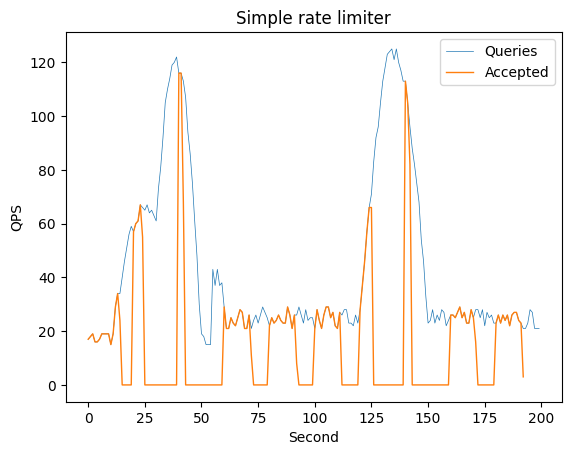

Total= 8692
Accepted= 5402


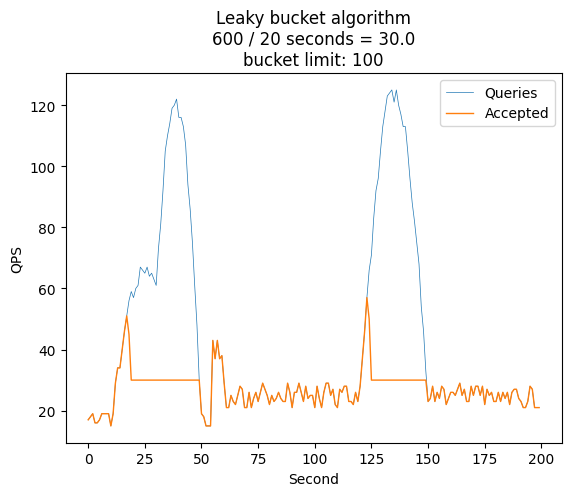

In [244]:
from collections import defaultdict

import matplotlib.pyplot as plt


def plottable(datapoints):
    count = defaultdict(int)
    min_value = sys.maxsize
    max_value = -sys.maxsize
    for num in datapoints:
        num_floor = int(num)
        min_value = min(min_value, num_floor)
        max_value = max(max_value, num_floor)
            
        count[num_floor] += 1
        
    for x in range(min_value, max_value + 1):
        if not x in count:
            count[x] = 0
    
    return count
        
def plot(datapoints, linewidth=1, label=None):
    counts = plottable(datapoints)
    counts_items = sorted(counts.items())
    x = [item[0] for item in counts_items]
    y = [item[1] for item in counts_items]
    plt.plot(x, y, linewidth=linewidth, label=label)



for algo in range(2):
    rate_limiter = None
    if algo == 0:
        rate_limiter = RateLimiter(limit=300, period=20)
    elif algo == 1:
        rate_limiter = LeakyBucket(limit=600, period=20, bucket_limit=100)
        
    # Plot count data as bar plot
    plot(qs, linewidth=0.5, label="Queries")
    accepted = []
    for q in qs:
        if rate_limiter.allow(q):
            accepted.append(q)
            
    print('Total=', len(qs))
    print('Accepted=', len(accepted))
            
    plot(accepted, linewidth=1, label="Accepted")

    plt.title(rate_limiter.name())
    plt.xlabel('Second')
    plt.ylabel('QPS')
    plt.legend()
    plt.show()